In [1]:
BATCH_SIZE = 3
EPOCHS = 10
#CHANGE VALIDATION AND TRAINING LABELS AXIS
#CHANGE DROP_REMAINDER FOR BATCHES

training_data_folder   = r"C:\Users\Aiden\OneDrive\Documents\training_data"
validation_data_folder = r"C:\Users\Aiden\OneDrive\Documents\validation_data"

In [2]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import nibabel, nibabel.processing
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.1


In [3]:
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float64)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 3//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [9]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(label):
    label = tf.one_hot(label, 3)
    return label
  
def read_image(file_path, new_size = [50, 64, 32]):
    input_path = r"C:\Users\Aiden\Downloads\MRI_Scans\ADNIDOD\0416233\Sagittal_3D_MPRAGE\2019-06-14_13_00_32.0\S867653\ADNIDOD_0416233_MR_Sagittal_3D_MPRAGE_br_raw_20190827183407525_73_S867653_I1219862.nii"
    #output_path = r"C:\Users\Aiden\Downloads\output_img.nii"

    img = nibabel.load(file_path)
    img = img.slicer[:,:,:,0]

    resampled_img = nibabel.processing.resample_from_to(img, ((50, 64, 32), img.affine))
    image_data = resampled_img.get_fdata()
    image_data = tf.convert_to_tensor(image_data, dtype=tf.float32)

    return image_data
  
def load_dataset(data_folder):
    class_folders = os.listdir(data_folder)
    imagedataset = []
    labeldataset = []
    for label, folder in enumerate(class_folders):
        files = [data_folder+"/"+folder+"/"+file for file in os.listdir(data_folder + "/" + folder)]
        imagedataset += files
        labeldataset += len(files) * [label]
        
    imagedataset = tf.data.Dataset.from_tensor_slices([read_image(file) for file in imagedataset])    
    labeldataset = tf.data.Dataset.from_tensor_slices(labeldataset)
    labeldataset = labeldataset.map(read_label, num_parallel_calls=16)

    dataset = tf.data.Dataset.zip((imagedataset, labeldataset))
    return dataset 
  
def get_training_dataset(data_folder, batch_size):
    dataset = load_dataset(data_folder)
    dataset = dataset.cache()
    dataset = dataset.shuffle(6, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset
  
def get_validation_dataset(data_folder):
    dataset = load_dataset(data_folder)
    dataset = dataset.cache()
    dataset = dataset.batch(3, drop_remainder=True)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(training_data_folder, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_data_folder)

training_input_fn = lambda: get_training_dataset(training_data_folder, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_data_folder)

In [5]:
print(training_dataset)
print(validation_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(3, 50, 64, 32), dtype=tf.float32, name=None), TensorSpec(shape=(3, 3), dtype=tf.float32, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(3, 50, 64, 32), dtype=tf.float32, name=None), TensorSpec(shape=(3, 3), dtype=tf.float32, name=None))>


In [6]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(50, 64, 32), target_shape=(50, 64, 32, 1)),
      
      tf.keras.layers.Conv3D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv3D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv3D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(100, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

plot_training = PlotTraining(sample_rate=10, zoom=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 50, 64, 32, 1)     0         
                                                                 
 conv3d (Conv3D)             (None, 50, 64, 32, 12)    324       
                                                                 
 batch_normalization (BatchN  (None, 50, 64, 32, 12)   36        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 50, 64, 32, 12)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 25, 32, 16, 24)    62208     
                                                                 
 batch_normalization_1 (Batc  (None, 25, 32, 16, 24)   72        
 hNormalization)                                        

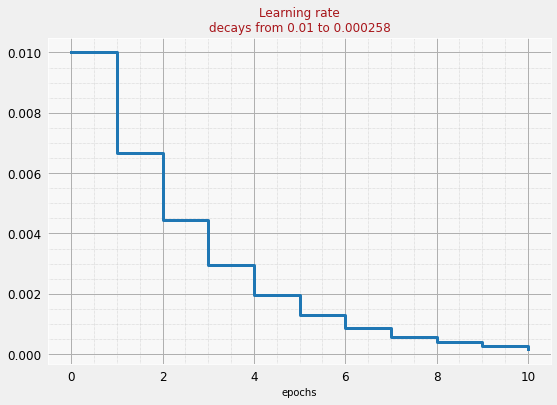

In [7]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

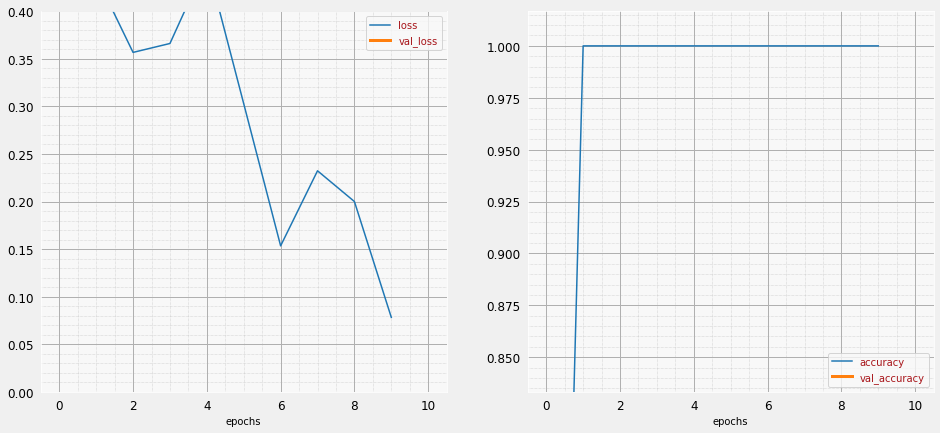

1/1 [==============================] - 1s 1s/step - loss: 0.0782 - accuracy: 1.0000 - val_loss: 468.8758 - val_accuracy: 0.3333 - lr: 2.5779e-04


In [8]:
steps_per_epoch = 3//BATCH_SIZE
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])